# Watson Machine Leaning testing with blind set

In this notebook we will score our deployed model using images never used by training or evaluation. Add a zip folder with your blind set of images to you Watson Studio Project.

This is the second notebook in the process, please make sure that you have deployed your model using the training notebook before using this one.

In [35]:
from PIL import Image as PImage
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
import numpy as np
import zipfile
from matplotlib import pyplot as plt

In [14]:
import json
import ibm_boto3
from ibm_botocore.client import Config, ClientError

def download_file_cos(local_file_name, key): 
    '''
    Wrapper function to download a file from cloud object storage using the
    credential dict provided and loading it into memory
    '''
    cos = ibm_boto3.client("s3",
        ibm_api_key_id=credentials_cos['IAM_SERVICE_ID'],
        ibm_service_instance_id=credentials_cos['IBM_API_KEY_ID'],
        config=Config(signature_version="oauth"),
        endpoint_url=credentials_cos['ENDPOINT']
    )
    try:
        res=cos.download_file(Bucket=credentials_cos['BUCKET'], Key=key, Filename=local_file_name)
    except Exception as e:
        print('Exception', e)
    else:
        print('File Downloaded')
        
def get_annotations(): 
    cos = ibm_boto3.client("s3",
        ibm_api_key_id=credentials_cos['IBM_API_KEY_ID'],
        ibm_service_instance_id=credentials_cos['IAM_SERVICE_ID'],
        config=Config(signature_version="oauth"),
        endpoint_url=credentials_cos['ENDPOINT']
    )
    try:
        return json.loads(cos.get_object(Bucket=credentials_cos['BUCKET'], Key='_annotations.json')['Body'].read())
    except Exception as e:
        print('Exception', e)

## Import the credentials using Watson Studio

In your data tab (101 Symbol) select your zip and using the option "Insert to Code" -> "Credentials". A cell just like the one below will pop, change the name of the variable to credentials_cos:

In [7]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_cos = {
    'IAM_SERVICE_ID': '<IAM_SERVICE_ID>',
    'IBM_API_KEY_ID': '<IBM_API_KEY_ID>',
    'ENDPOINT': '<ENDPOINT>',
    'IBM_AUTH_ENDPOINT': '<IBM_AUTH_ENDPOINT>',
    'BUCKET': '<BUCKET>',
    'FILE': '<FILE>'
}


In [3]:
import os
import sys
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/cloud-annotations/models

%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

Cloning into 'models'...
remote: Enumerating objects: 2282, done.
remote: Counting objects: 100% (2282/2282), done.
remote: Compressing objects: 100% (1930/1930), done.
remote: Total 2282 (delta 523), reused 1238 (delta 326), pack-reused 0
Receiving objects: 100% (2282/2282), 30.58 MiB | 43.74 MiB/s, done.
Resolving deltas: 100% (523/523), done.
/home/wsuser/work/models/research


In [4]:
if os.path.exists('blind') and os.path.isdir('blind'):
    shutil.rmtree('blind')
    
os.makedirs('blind', exist_ok=True)

### Use your file name or credentials_cos['File'] to add your zip to the notebook

In [8]:
download_file_cos(os.path.join('blind', 'guns_test.zip'), 'guns_test.zip')

File Downloaded


In [9]:
with zipfile.ZipFile(os.path.join('blind', 'guns_test.zip'), 'r') as zip_ref:
    zip_ref.extractall('blind')

In [10]:
%ls blind

319.jpeg  322.jpeg  325.jpeg  328.jpeg  331.jpeg  guns_test.zip
320.jpeg  323.jpeg  326.jpeg  329.jpeg  332.jpeg  __MACOSX/
321.jpeg  324.jpeg  327.jpeg  330.jpeg  333.jpeg


## Scoring Step

You will need a Watson Machine Leaning instance and an IAM API Key in IBM Cloud that has access to this instance. See the steps in the documentation:

https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-authentication.html

Also, in the new version of WML you will need a Deployment Space and it's ID

https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-spaces_local.html?audience=wdp

In [11]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey":"<apikey>"
                  }

client = APIClient(wml_credentials)

In [12]:
client.set.default_space("<deployment-space-id>")

'SUCCESS'

## Get the deployment ID of your model

The next cell will list all the deployments available in your instance.

In [ ]:
client.deployments.list()

In [50]:
labels = ['N/A','Pistol','Rifle']

In [51]:
with open('blind/label_map.pbtxt', 'w') as f:
  # Loop through all of the labels and write each label to the file with an id
  for idx, label in enumerate(labels):
    f.write('item {\n')
    f.write("\tname: '{}'\n".format(label))
    f.write('\tid: {}\n'.format(idx + 1)) # indexes must start at 1
    f.write('}\n')

In [52]:
category_index = label_map_util.create_category_index_from_labelmap('blind/label_map.pbtxt', use_display_name=True)

In [21]:
test_images = []
for filename in os.listdir('blind'):
    if filename.endswith("jpeg"): 
        test_images.append(filename)
        continue
    else:
        continue

In [22]:
test_images

['324.jpeg',
 '332.jpeg',
 '327.jpeg',
 '323.jpeg',
 '322.jpeg',
 '325.jpeg',
 '321.jpeg',
 '326.jpeg',
 '333.jpeg',
 '320.jpeg',
 '331.jpeg',
 '330.jpeg',
 '328.jpeg',
 '319.jpeg',
 '329.jpeg']

In [24]:
image = PImage.open(os.path.join('blind', test_images[0]))
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
(im_width, im_height) = image.size
image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [25]:
data = image_np.tolist()
payload_scoring = {
  "input_data": [{
    "values": [data]
  }]
}

# Use the deployment ID of your model

In [27]:
%%time
predictions = client.deployments.score('<deployment-id>', payload_scoring)

CPU times: user 25.4 ms, sys: 16.8 ms, total: 42.2 ms
Wall time: 7.81 s


In [34]:
for x in predictions['predictions']:
    if x['id'] == 'detection_scores':
        scores = x['values'][0]
    if x['id'] == 'detection_boxes':
        boxes = x['values'][0]
    if x['id'] == 'num_detections':
        num = x['values'][0]
    if x['id'] == 'detection_classes':
        classes = x['values'][0]

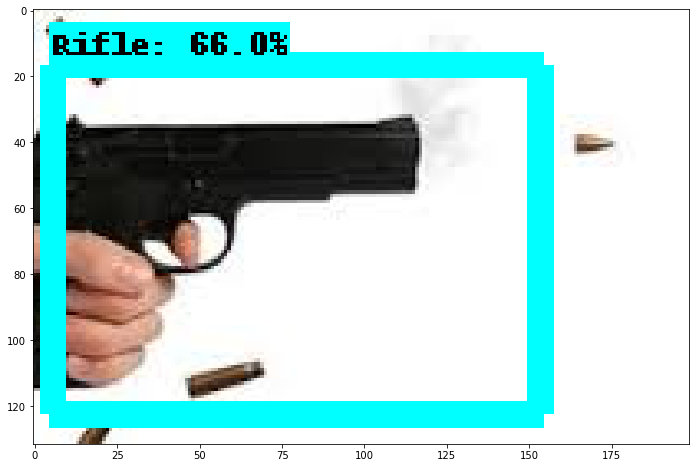

In [36]:
%matplotlib inline
vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8)

plt.figure(figsize=(12, 8))
plt.imshow(image_np)

In [53]:
%%time
bbox_images = []
for image_path in test_images:
    image = PImage.open(os.path.join('blind', image_path))
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    (im_width, im_height) = image.size
    image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    data = image_np.tolist()
    payload_scoring = {
      "input_data": [{
        "values": [data]
      }]
    }
    predictions = client.deployments.score('<deployment-id>', payload_scoring)
    for x in predictions['predictions']:
        if x['id'] == 'detection_scores':
            scores = x['values'][0]
        if x['id'] == 'detection_boxes':
            boxes = x['values'][0]
        if x['id'] == 'num_detections':
            num = x['values'][0]
        if x['id'] == 'detection_classes':
            classes = x['values'][0]
    
    vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8,
            min_score_thresh=0.6)
    
    bbox_images.append(image_np)

CPU times: user 2.98 s, sys: 31.3 ms, total: 3.01 s
Wall time: 15.9 s


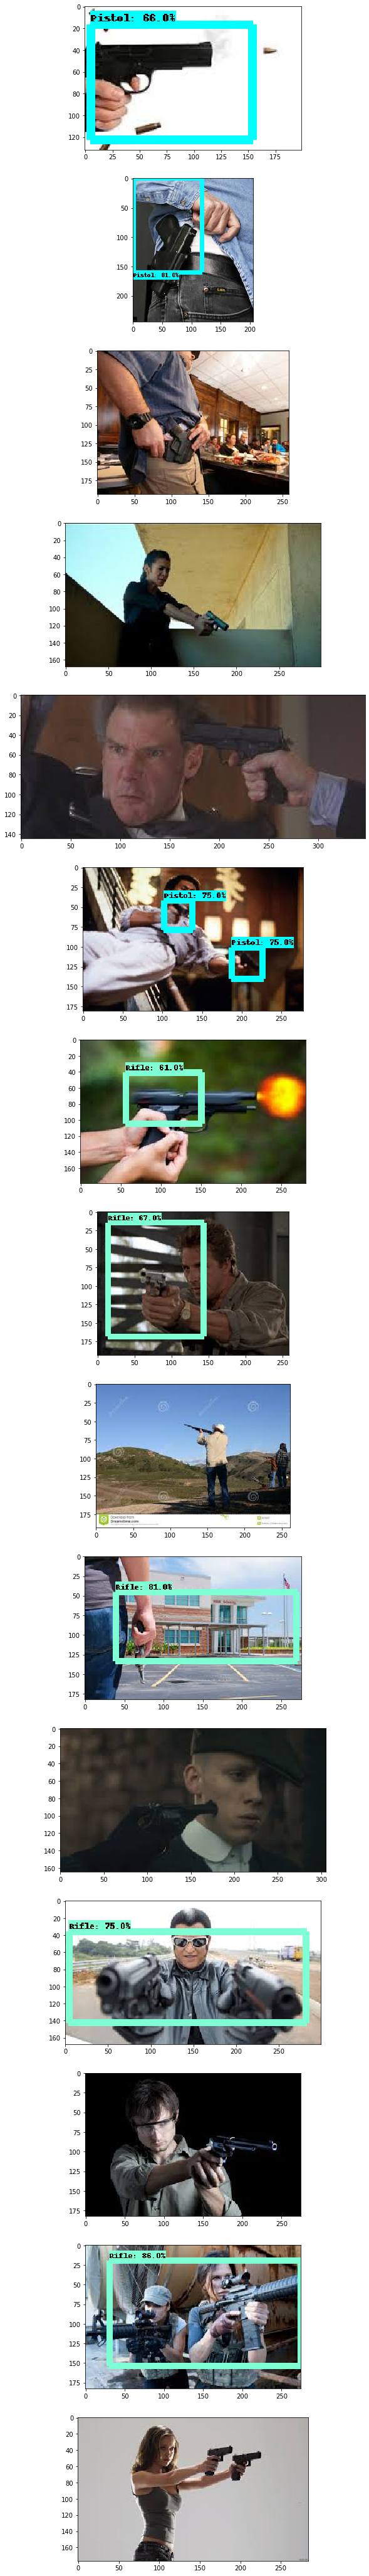

In [54]:
%matplotlib inline

fig = plt.figure(figsize=(120, 80))  # width, height in inches

for i,bbox_image in enumerate(bbox_images):
    sub = fig.add_subplot(len(bbox_images)+1, 1, i + 1)
    sub.imshow(bbox_image, interpolation='nearest')

## Tip: You can change the variable min_score_thresh if your confidence scores are too low.